# This notebook gives an introduction to the xcube's "zenodo" data store and its preload_data method

This notebook shows an example how to preload a Zarr file, whcih is published in compressed tar format on the [https://zenodo.org](https://zenodo.org) webpage. The compressed files will be downloaded, unpacked and the the Zarr files will be made available, which can be subsequently used by the data store as usual. 

### Setup
In order to run this notebook you need to get an access token for the Zenodo API following the [documentation](https://zenodo.org/login/?next=%2Faccount%2Fsettings%2Fapplications%2Ftokens%2Fnew%2F). Furthermore, make sure that [`xcube_zenodo`](https://github.com/xcube-dev/xcube-zenodo) is installed. You may install [`xcube_zenodo`](https://github.com/xcube-dev/xcube-zenodo) directly from the git repository by cloning the repository, directing into `xcube-zenodo`, and following the steps below:

```bash
conda env create -f environment.yml
conda activate xcube-zenodo
pip install .
```

Note that [`xcube_zenodo`](https://github.com/xcube-dev/xcube-zenodo) is a plugin of [`xcube`](https://xcube.readthedocs.io/en/latest/), where `xcube` is included in the `environment.yml`.  

Now, we first import everything we need:

In [1]:
%%time
from xcube.core.store import new_data_store
from xcube.core.store import get_data_store_params_schema

CPU times: user 3.95 s, sys: 471 ms, total: 4.42 s
Wall time: 3.15 s


First, we get the store parameters needed to initialize a zenodo [data store](https://xcube.readthedocs.io/en/latest/dataaccess.html#data-store-framework). 

In [2]:
%%time
store_params = get_data_store_params_schema("zenodo")
store_params

CPU times: user 99.6 ms, sys: 32.1 ms, total: 132 ms
Wall time: 146 ms


We initiate a zenodo [data store](https://xcube.readthedocs.io/en/latest/dataaccess.html#data-store-framework) with the access_token. Note that the `xcube-zenodo` plugin is recognized after installation by setting the first argument to `"zenodo"` in the `new_data_store` function. Optionally, we can add a relative path to a folder where preloaded data will be stored. Defaults are set to `"zenodo_cache"`. 

In [3]:
%%time
access_token = "fill in your Zenodo access token here"
store = new_data_store("zenodo", access_token=access_token)

CPU times: user 6.19 ms, sys: 22 μs, total: 6.21 ms
Wall time: 6.14 ms


Compressed files can be preloaded using the `preload_data` method. Also this method uses `preload_params`, which can be viewed in the next cell.

In [4]:
%%time
preload_params = store.get_preload_data_params()
preload_params

CPU times: user 34 μs, sys: 0 ns, total: 34 μs
Wall time: 36 μs


 This approach enables the downloading of compressed files that cannot be lazily loaded, allowing them to be stored and readily available for the duration of the project. The `preload_data` method is non-blocking and returns a handler which can be used to cancel the preload by typing `handler.cancel()` indto the next cell. Note that the `preload_method` is new and highly experimental.

In [5]:
handler = store.preload_data(
    "11546130/EventCube_ranked_pot0.01_ne0.1.zarr.zip",
    "11546130/mergedlabels.zarr.zip"
)

Data ID,Status,Progress,Message
11546130/EventCube_ranked_pot0.01_ne0.1.zarr.zip,Preloaded,nan%,
11546130/mergedlabels.zarr.zip,Preloaded,nan%,


The data IDs can be viewed using the following line. The new data ID is identical to the original, except that the `.zip` extension indicating a compressed format has been removed.

In [6]:
store.cache_store.list_data_ids()

['13333034/belgium/number_disturbances_belgium.zarr',
 '13333034/belgium/annual_disturbances_1985_2023_belgium.zarr',
 '13333034/belgium/latest_disturbance_belgium.zarr',
 '13333034/belgium/disturbance_agent_1985_2023_belgium.zarr',
 '13333034/belgium/forest_mask_belgium.zarr',
 '13333034/belgium/disturbance_agent_aggregated_belgium.zarr',
 '13333034/belgium/greatest_disturbance_belgium.zarr',
 '13333034/belgium/disturbance_probability_1985_2023_belgium.zarr',
 '13333034/belgium/disturbance_severity_1985_2023_belgium.zarr',
 '13333034/denmark/disturbance_severity_1985_2023_denmark.zarr',
 '13333034/denmark/latest_disturbance_denmark.zarr',
 '13333034/denmark/disturbance_probability_1985_2023_denmark.zarr',
 '13333034/denmark/disturbance_agent_aggregated_denmark.zarr',
 '13333034/denmark/number_disturbances_denmark.zarr',
 '13333034/denmark/annual_disturbances_1985_2023_denmark.zarr',
 '13333034/denmark/greatest_disturbance_denmark.zarr',
 '13333034/denmark/forest_mask_denmark.zarr',
 '

Next we want to open one of the datasets. We first view the availbale parameters to open the data. 

In [8]:
%%time
open_params = store.get_open_data_params_schema(
    data_id="11546130/EventCube_ranked_pot0.01_ne0.1.zarr"
)
open_params

CPU times: user 681 μs, sys: 0 ns, total: 681 μs
Wall time: 686 μs


In [9]:
%%time
ds = store.open_data("11546130/EventCube_ranked_pot0.01_ne0.1.zarr")
ds

CPU times: user 24 ms, sys: 4 ms, total: 28 ms
Wall time: 36.5 ms


<xarray.Dataset> Size: 111GB
Dimensions:    (latitude: 721, longitude: 1440, time: 26663)
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 213kB 1950-01-01 1950-01-02 ... 2022-12-31
Data variables:
    layer      (latitude, longitude, time) float32 111GB dask.array<chunksize=(6, 120, 5844), meta=np.ndarray>

We plot the opened data at the last time step as an example below.

CPU times: user 6.75 s, sys: 1.71 s, total: 8.46 s
Wall time: 2.43 s


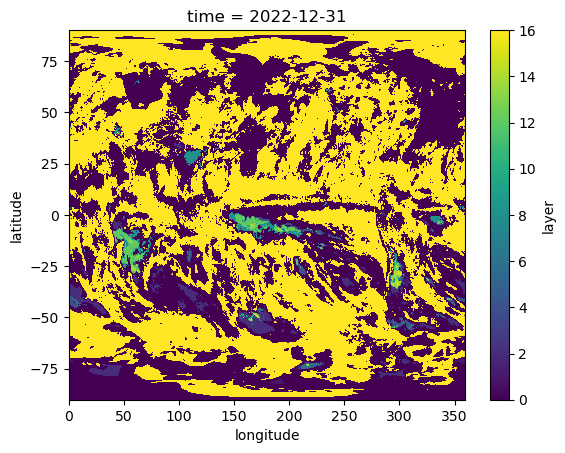

In [10]:
%%time
ds.layer.isel(time=-1).plot()